## Speed Dating dataset analysis
In this notebook, our goal is to analyze all the scikit learn pipelines that are executed on the task 146607 (https://www.openml.org/t/146607) which is a supervised classficaiton task using the speed dating dataset (https://www.openml.org/d/40536).
First, we find all the (scikit learn) pipelines and their specific runs (hyper-parameter settings).
Using these pipelines and runs, we populate the database.
Then we the pipeline graph.
Using the pipeline graph, we show how we can speed up the process of pipeline execution and hyperparamter search.

After finding all the "good" pipelines, there are two strategies that we can use for the experiment:
- Order all the runs based on their timestamp, start from an empty database
- Divide the pipelines into two groups, populate the databse with one group, and use the other group to execute the workload (incrementally)



In [1]:
from openml import datasets, tasks, runs, flows, setups, config, evaluations
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import uuid
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
%matplotlib inline

config.apikey = '8e2079508005379adb9a60798696134e'
config.server = 'https://www.openml.org/api/v1'
config.set_cache_directory(os.path.expanduser('~/openml-cache'))

The task '146607' has around 16000 runs, but we are only interested in high quality runs and ones that actually have meaningfull pipelines. 
Therefore, we will only get the runs for the following flows (pipelines):

``[6970, 6969, 7707,8330,7756,6952,7096,7097,7722,7694,7103]``

In [2]:
TASK_IDS = [146607]
# 6969, 8330, 7694 has wrong order in openml (model is first)
FLOW_IDS = [6970, 7707,6952,7103]
PIPELINES = dict()
# query the flows from openml
for f in FLOW_IDS:
    PIPELINES[f] = flows.get_flow(flow_id=f)

In [4]:
def getTopRuns(numberOfRuns, pipeline, task):
    offset = 0
    frames = []
    while True:
        try:
            evaluationList = evaluations.list_evaluations('predictive_accuracy', \
                                                          task= [task], flow = [pipeline], offset = offset, size = 10000)
            frames.append(pd.DataFrame.from_dict(evaluationList,orient='index'))
            offset = offset + 10000
        except:
            break
    evaluationResults = pd.concat(frames)
    evaluationResults['accuracy'] = evaluationResults.apply(lambda eva: eva.values[0].value, axis = 1)
    evaluationResults['run_id'] = evaluationResults.apply(lambda eva: eva.values[0].run_id, axis = 1)
    topRuns = evaluationResults.sort_values('accuracy',ascending=False)[0:numberOfRuns] 
    offset = 0
    frames = []
    while True:
        try:
            experimentList = runs.list_runs(task=[task], flow=[pipeline], size = 10000, offset = offset)
            frames.append(pd.DataFrame.from_dict(experimentList,orient='index'))
            offset = offset + 10000
        except:
            break
            
    allExperiments = pd.concat(frames)
    Experiment = allExperiments[allExperiments.apply(lambda e: e.run_id in topRuns.run_id, axis = 1)].reset_index(drop=True).drop(columns=['uploader'])
    Setup = pd.DataFrame.from_dict(setups.list_setups(setup=Experiment.setup_id), orient='index').reset_index()
    Setup.columns=['id', 'setup']
    
    return pd.merge(Setup, Experiment, how = 'inner', left_on='id', right_on='setup_id').drop(columns = ['id','setup_id'])[['run_id','task_id','flow_id', 'setup']]

Populate the database with top 10 runs of the specified pipelies and tasks

In [5]:
frames = []
for t in TASK_IDS:
    for f in FLOW_IDS:
        frames.append(getTopRuns(50,f,t))
        
Experiments = pd.concat(frames).reset_index(drop=True)

In [6]:
Experiments.head()

,run_id,task_id,flow_id,setup
0,6145352,146607,6970,<openml.setups.setup.OpenMLSetup object at 0x1...
1,6117002,146607,6970,<openml.setups.setup.OpenMLSetup object at 0x1...
2,6152594,146607,6970,<openml.setups.setup.OpenMLSetup object at 0x1...
3,6146642,146607,6970,<openml.setups.setup.OpenMLSetup object at 0x1...
4,6117783,146607,6970,<openml.setups.setup.OpenMLSetup object at 0x1...


In [7]:
class Component:
    def __init__(self, name, fullName, parameters):
        self.name = name
        self.params = parameters
        self.fullName = fullName
    
    def equals(self,other):
        if self.name != other.name:
            return False
        if self.fullName != other.fullName:
            return False
        if len(self.params) != len(other.params):
            return False
        for key in self.params.keys():
            if self.params[key] != other.params[key]:
                return False
        return True   
    def toString(self):
        return '%s , %s' % (self.name, self.params)
        
    
    name = ""
    fullName = ""
    params = dict()
    
class ExperimentObject:
    def __init__(self, run, flow, task):
        self.run = run
        self.flow = flow
        self.task = task
        self.components = []
        
    def toString(self):
        return '%(run)d, %(flow)d, %(task)d, %(components)s' %\
    {'run':self.run, 'flow':self.flow, 'task': self.task, 'components':[comp.name for comp in self.components]}
    
    def equals(self, other):
        if self.flow != other.flow:
            return False
        if self.task != other.task:
            return False
        if len(self.components) != len(other.components):
            return False
        for i in range(len(self.components)):
            if not self.components[i].equals(other.components[i]):
                return False
        return True
    run = 0    
    flow = 0
    task = 0
    components = []

The table 'Experiment' contains all the required info for consturcting our graph.
From the table, we can construct the ExperimentObjects which are executed pipelines on a dataset.

In [8]:
Experiments.head()

,run_id,task_id,flow_id,setup
0,6145352,146607,6970,<openml.setups.setup.OpenMLSetup object at 0x1...
1,6117002,146607,6970,<openml.setups.setup.OpenMLSetup object at 0x1...
2,6152594,146607,6970,<openml.setups.setup.OpenMLSetup object at 0x1...
3,6146642,146607,6970,<openml.setups.setup.OpenMLSetup object at 0x1...
4,6117783,146607,6970,<openml.setups.setup.OpenMLSetup object at 0x1...


Before generalizing the extraction code, we are going to extract the information required for creating one ExperimentObject

In [9]:
def extractExperimentObject(run,flow,task,setup):
    pipeline = PIPELINES[flow]
    assert pipeline.flow_id == setup.flow_id
    experimentObject = ExperimentObject(run, flow,task)
    for componentKey,componentValue in pipeline.components.items():
        prefix = componentKey
        fullName = componentValue.class_name
        componentParams = dict()
        for paramKey,paramValue in setup.parameters.items():
            if paramValue.full_name.startswith(fullName):
                componentParams[paramValue.parameter_name] = paramValue.value
        comp = Component(prefix, fullName, componentParams)
        experimentObject.components.append(comp)
    return experimentObject

In [10]:
experimentObjects = []
for index,row in Experiments.iterrows():
    experimentObjects.append(extractExperimentObject(row.run_id,row.flow_id,row.task_id,row.setup))

## Graph Construction

In [11]:
# Update the graph by add the experiment object
def updateGraph(graph, experimentObject):
    if not graph.has_node(experimentObject.task):
        graph.add_node(experimentObject.task, label = experimentObject.task)
    # setting the starting point to root
    v = experimentObject.task
    for c in experimentObject.components:
        added = False
        for e in graph.out_edges(v):  
            if c.equals(graph[e[0]][e[1]]['transformation']):
                graph[e[0]][e[1]]['weight'] += 1
                v = e[1]
                added = True
                break
        if not added:
            dataset_id = str(uuid.uuid4())
            graph.add_node(dataset_id, label = '')
            graph.add_edge(v,dataset_id, name = c.name, weight = 1, transformation = c)
            v = dataset_id 

In [22]:
# construct the directed graph (for now we only support acyclic graphs)
graph = nx.DiGraph()

In [23]:
for obj in experimentObjects:
    updateGraph(graph, obj)

In [27]:
def prettyLabel(edgeLabel):
    if (edgeLabel['weight'] <= 1):
        return ''
    else:
        return '{} , ({})'.format(edgeLabel['name'], edgeLabel['weight'])

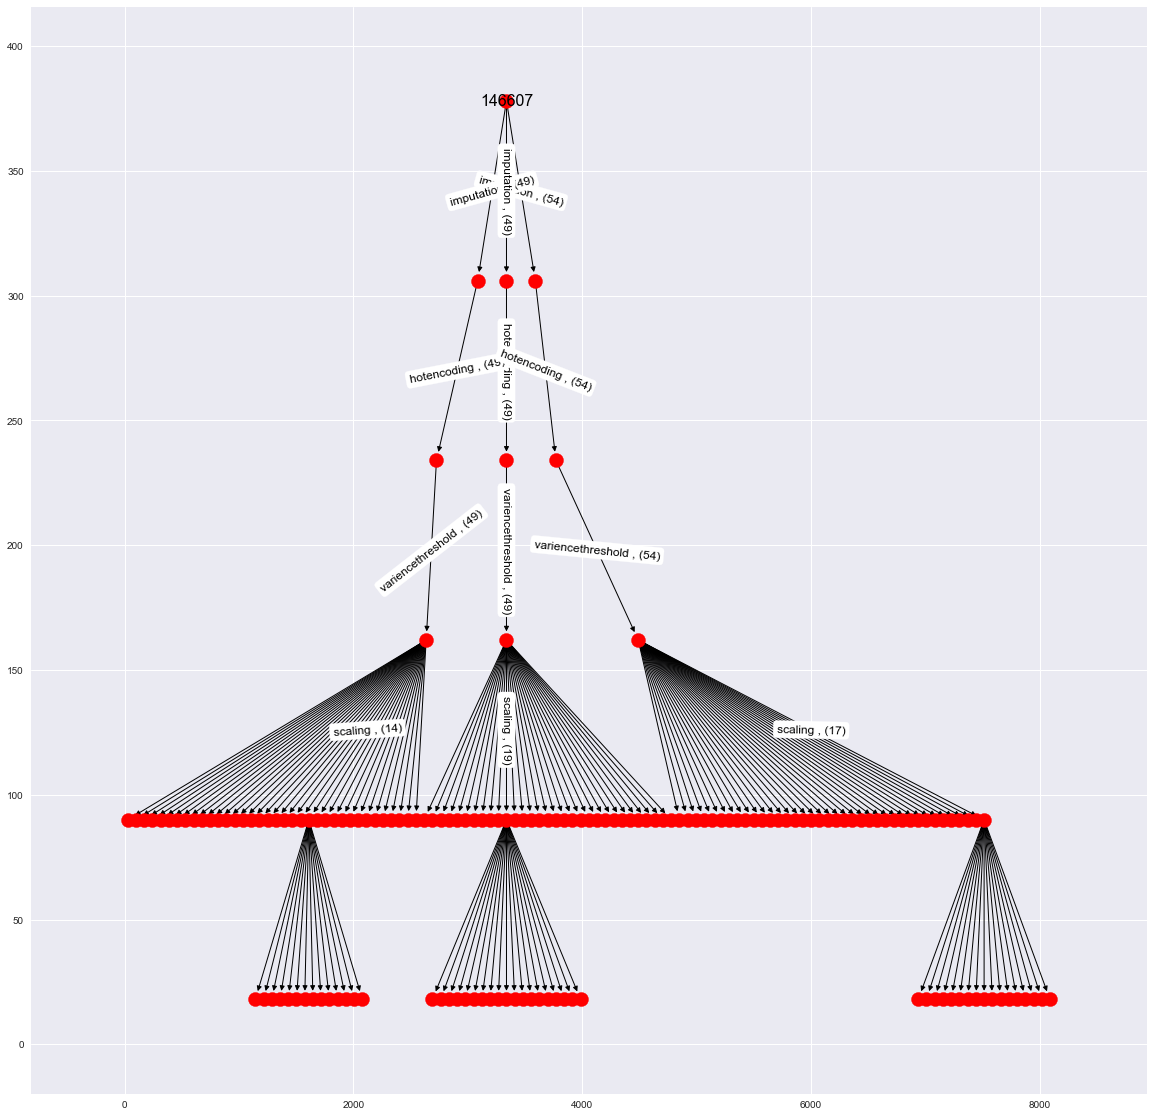

In [28]:
edge_labels = dict([((u,v,),prettyLabel(d)) for u,v,d in graph.edges(data=True)])
labels = dict({k for k in graph.nodes(data ='label')})
pos = graphviz_layout(graph, prog='dot')
gp = plt.figure(figsize=(20, 20))
nx.draw_networkx_edge_labels(graph, pos, alpha=1, edge_labels=edge_labels, font_size=12)
nx.draw_networkx_nodes(graph, pos, node_size=200)
nx.draw_networkx_edges(graph, pos, alpha=1,arrows=True)
nx.draw_networkx_labels(graph,pos,labels=labels, font_size=16)
gp.savefig("graph.png")

In [59]:
for k,p in PIPELINES.items():
    components = ' ===> '.join([c for c in p.components.keys()])
    print '{} : {}'.format(k,components)

6952 : imputation ===> hotencoding ===> variencethreshold ===> classifier
6970 : imputation ===> hotencoding ===> variencethreshold ===> classifier
7707 : imputation ===> hotencoding ===> variencethreshold ===> scaling ===> classifier
7103 : imputation ===> hotencoding ===> variencethreshold ===> classifier


In [34]:
PIPELINES.items

<function items>